# ============================================================================
# Aureus Sigma Capital - Phase 22: Canonical Backtest Engine
# Notebook: 22_canonical_backtest_engine.ipynb
#
# Objective:
#   To build a single, definitive, and reusable backtesting engine for a
#   production-style strategy. This engine will serve as the "golden path"
#   template for the full 12-cell test matrix.
#
#   This notebook will first implement and validate the engine for the
#   "Standalone Value" strategy, then apply the same engine to the
#   "QVR_60_20_20" composite for a direct, apples-to-apples comparison.
# ============================================================================
#
# --- BASELINE STRATEGY REFERENCE ---
#
# This engine is built upon the validated methodologies from our most successful prior work:
#
# 1.  **Standalone Value Baseline:**
#     - **Source:** `16b_extended_backtest_2016_2025.md`
#     - **Key Result:** Sharpe Ratio of 2.60 over the full 2016-2025 period.
#     - **Inherited Logic:** Full-period backtesting structure, dynamic universe construction.
#
# 2.  **Composite Logic Baseline:**
#     - **Source:** `16_weighted_composite_engineering.md`
#     - **Key Result:** Validated the methodology for creating weighted composites.
#     - **Inherited Logic:** The critical process of re-normalizing individual factor
#       scores within the liquid universe *before* combining them.
#
# --- KEY UPGRADES IN THIS ENGINE ---
#
# This backtest is NOT a replication. It introduces critical upgrades to bridge
# the gap from theoretical research to practical implementation:
#
# 1.  **Portfolio Construction -> From Quintile to Concentrated:**
#     - **Baseline:** Used the top quintile (top 20% of the liquid universe), which
#       resulted in a variable portfolio size (e.g., 15 to 40 stocks).
#     - **Upgrade:** Implements a **fixed portfolio size of 20 stocks**. This tests
#       a more concentrated, practical strategy suitable for our fund size and
#       management capacity.
#
# 2.  **Engine Design -> From Procedural to Object-Oriented:**
#     - **Baseline:** Procedural scripts tailored to a specific test.
#     - **Upgrade:** A more robust, reusable `CanonicalBacktester` class structure
#       that can be easily configured to run different strategies, forming the
#       foundation for the full test matrix.
#
# 3.  **Focus -> From Discovery to Auditability:**
#     - **Baseline:** Focused on discovering alpha signals.
#     - **Upgrade:** Focused on creating a clean, auditable, end-to-end process
#       that can be handed to a risk manager or investor for due diligence.
#
# --- METHODOLOGY OVERVIEW (THE 5 PHASES) ---
#
# This notebook will execute the following five phases in a clear, sequential manner:
#
#   - **Phase 1: Setup & Configuration:** Define all backtest parameters in one place.
#   - **Phase 2: Data Preparation:** Load all raw factor, price, and benchmark data.
#   - **Phase 3: The Canonical Backtesting Loop:** The core engine that iterates through
#     rebalance periods, constructs the universe, re-normalizes factors, and forms
#     the target portfolio.
#   - **Phase 4: Return Calculation:** Compute daily gross and net returns, accounting
#     for transaction costs and preventing look-ahead bias.
#   - **Phase 5: Performance Analysis:** Generate a full institutional tearsheet to
#     evaluate the final performance.
#

In [1]:
# ============================================================================
# PHASE 1: SETUP & CONFIGURATION (REFACTORED)
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import pickle
from pathlib import Path
import sys

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- CORRECTED Module Import Logic ---
# The goal is to add the project's root directory (e.g., 'factor_investing_project')
# to the system path, so that we can import from the 'production' package.
try:
    # This assumes the notebook is in: .../factor_investing_project/production/tests/phase22...
    # We need to go up three levels to reach the project root.
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
        print(f"✅ Project root added to sys.path: {project_root}")

    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")

except ImportError as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Attempted Project Root: {project_root}")
    print(f"   - Error: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred during import: {e}")


# --- Standardized Institutional Visualization Palette ---
# Inherited from Phase 16b for consistency
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})
print("✅ Visualization settings configured.")


# --- Core Backtest Configuration ---
# This dictionary will drive the entire backtest.
# We will start with the 'Standalone Value' strategy.
CONFIG = {
    "strategy_name": "Standalone_Value",
    "factor_to_use": "Value_Composite",
    "backtest_start_date": "2015-12-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "portfolio_size": 20,
    "transaction_cost_bps": 30,
    "strategy_version_db": "qvm_v2.0_enhanced" # The version to pull from the database
}

print("✅ Backtest configuration defined for 'Standalone Value' strategy.")
print(f"   - Portfolio Size: {CONFIG['portfolio_size']} stocks")
print(f"   - Rebalancing: {CONFIG['rebalance_frequency']} (Quarterly)")
print(f"   - Period: {CONFIG['backtest_start_date']} to {CONFIG['backtest_end_date']}")

✅ Project root added to sys.path: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project
✅ Successfully imported production modules.
✅ Visualization settings configured.
✅ Backtest configuration defined for 'Standalone Value' strategy.
   - Portfolio Size: 20 stocks
   - Rebalancing: Q (Quarterly)
   - Period: 2015-12-01 to 2025-07-28


In [2]:
# ============================================================================
# PHASE 2: DATA PREPARATION
# ============================================================================

# --- Database Connection ---
def create_db_connection():
    """
    Establishes a SQLAlchemy database engine connection using the central config file.
    """
    try:
        # Path is relative to the project root, which we added to sys.path
        config_path = project_root / 'config' / 'database.yml'
        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)['production']
        
        connection_string = (
            f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
            f"@{db_config['host']}/{db_config['schema_name']}"
        )
        
        engine = create_engine(connection_string, pool_pre_ping=True)
        
        # Test the connection
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
            
        print(f"✅ Database connection established successfully to schema '{db_config['schema_name']}'.")
        return engine

    except Exception as e:
        print(f"❌ FAILED to connect to the database.")
        print(f"   - Config path checked: {config_path}")
        print(f"   - Error: {e}")
        return None

# Create the engine for this session
engine = create_db_connection()

# --- Load Raw Data for the Full Backtest Period ---
if engine:
    print("\n📂 Loading all raw data for the full backtest period...")

    db_params = {
        'start_date': CONFIG['backtest_start_date'],
        'end_date': CONFIG['backtest_end_date'],
        'strategy_version': CONFIG['strategy_version_db']
    }

    # 1. Factor Scores (Full Universe for all three factors for future use)
    # We load all three now to make the engine easily adaptable for the QVR test later.
    factor_query = text("""
        SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
        FROM factor_scores_qvm
        WHERE date BETWEEN :start_date AND :end_date 
          AND strategy_version = :strategy_version
    """)
    factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(factor_data_raw):,} raw factor observations.")

    # 2. Price Data
    price_query = text("""
        SELECT date, ticker, close 
        FROM equity_history
        WHERE date BETWEEN :start_date AND :end_date
    """)
    price_data_raw = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(price_data_raw):,} raw price observations.")

    # 3. Benchmark Data
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(benchmark_data_raw):,} benchmark observations.")

    # --- Prepare Data Structures for Backtesting ---
    print("\n🛠️  Preparing data structures for the backtesting engine...")

    # 1. Calculate daily returns and create the returns matrix
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    print(f"   - ✅ Daily returns matrix constructed. Shape: {daily_returns_matrix.shape}")

    # 2. Calculate benchmark returns
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    print(f"   - ✅ Benchmark returns calculated. Days: {len(benchmark_returns)}")

    print("\n✅ All data prepared. Ready for the canonical backtesting loop.")
else:
    print("\n❌ Halting execution due to database connection failure.")

✅ Database connection established successfully to schema 'alphabeta'.

📂 Loading all raw data for the full backtest period...
   - ✅ Loaded 1,567,488 raw factor observations.
   - ✅ Loaded 1,623,168 raw price observations.
   - ✅ Loaded 2,411 benchmark observations.

🛠️  Preparing data structures for the backtesting engine...
   - ✅ Daily returns matrix constructed. Shape: (2408, 728)
   - ✅ Benchmark returns calculated. Days: 2411

✅ All data prepared. Ready for the canonical backtesting loop.


In [3]:
# =_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=
# PHASE 3, 4, 5: THE CANONICAL BACKTESTER CLASS (REFACTORED v1.3 - FULL TEARSHEET)
# This version integrates a full, institutional-grade tearsheet for comprehensive
# performance analysis, inherited from our validated notebook 16b.
#_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=_=

from typing import Dict, List, Optional # For type hinting

class CanonicalBacktester:
    """
    A self-contained, configurable backtesting engine for our production-style strategies.
    """
    def __init__(self,
                 config: Dict,
                 factor_data: pd.DataFrame,
                 returns_matrix: pd.DataFrame,
                 benchmark_returns: pd.Series,
                 db_engine):
        
        self.config = config
        self.factor_data_raw = factor_data.copy()
        self.daily_returns_matrix = returns_matrix
        self.benchmark_returns = benchmark_returns
        self.engine = db_engine
        
        self.factor_data_raw['date'] = pd.to_datetime(self.factor_data_raw['date'])
        
        print(f"✅ CanonicalBacktester v1.3 (Full Tearsheet) initialized for strategy: '{self.config['strategy_name']}'")

    def run(self) -> pd.Series:
        """
        Executes the full, end-to-end backtest.
        """
        print(f"\n--- Executing Backtest for Period: {self.config['backtest_start_date']} to {self.config['backtest_end_date']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns = self._calculate_net_returns(daily_holdings)
        self._generate_tearsheet(net_returns)
        
        print(f"\n✅ Backtest for start date {self.config['backtest_start_date']} complete.")
        return net_returns

    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        all_trading_dates = self.daily_returns_matrix.index
        freq_ends = pd.date_range(
            start=self.config['backtest_start_date'],
            end=self.config['backtest_end_date'],
            freq=self.config['rebalance_frequency']
        )
        rebalance_dates = [
            all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1]
            for q_end in freq_ends 
            if q_end <= all_trading_dates.max() and q_end >= all_trading_dates.min()
        ]
        return rebalance_dates

    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        all_tickers = self.daily_returns_matrix.columns
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=all_tickers)

        for i in range(len(rebalance_dates)):
            rebal_date = rebalance_dates[i]
            
            universe_df = get_liquid_universe_dataframe(
                analysis_date=rebal_date, engine=self.engine,
                config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6}
            )
            liquid_tickers = universe_df['ticker'].tolist()

            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date_all = self.factor_data_raw.loc[mask]
            
            if factors_on_date_all.empty: continue
            
            factors_on_date = factors_on_date_all[factors_on_date_all['ticker'].isin(liquid_tickers)].copy()
            
            if len(factors_on_date) < self.config['portfolio_size']: continue

            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values

        return daily_holdings

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        factor_scores = factors_df[self.config['factor_to_use']]
        liquid_mean = factor_scores.mean()
        liquid_std = factor_scores.std()
        
        if liquid_std > 0:
            factors_df['final_signal'] = (factor_scores - liquid_mean) / liquid_std
        else:
            factors_df['final_signal'] = 0.0

        top_n_stocks = factors_df.nlargest(self.config['portfolio_size'], 'final_signal')
        weight = 1.0 / len(top_n_stocks)
        return pd.Series(weight, index=top_n_stocks['ticker'])

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1)
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        return (gross_returns - costs).rename(self.config['strategy_name'])

    def _calculate_performance_metrics(self, returns: pd.Series) -> Dict:
        first_trade_date = returns.loc[returns != 0].index.min()
        common_index = returns.loc[first_trade_date:].index.intersection(self.benchmark_returns.index)
        returns, benchmark = returns.loc[common_index], self.benchmark_returns.loc[common_index]

        n_years = len(returns) / 252
        annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
        annual_vol = returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
        
        cumulative = (1 + returns).cumprod()
        drawdown = (cumulative / cumulative.cummax() - 1)
        max_drawdown = drawdown.min()
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
        
        excess_returns = returns - benchmark
        tracking_error = excess_returns.std() * np.sqrt(252)
        information_ratio = (excess_returns.mean() * 252) / tracking_error if tracking_error > 0 else 0
        
        cov_matrix = np.cov(returns.fillna(0), benchmark.fillna(0))
        beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
        alpha_daily = returns.mean() - beta * benchmark.mean()
        alpha_annualized = alpha_daily * 252
        
        return {
            'Annual Return (%)': annual_return * 100, 'Annual Volatility (%)': annual_vol * 100,
            'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown * 100,
            'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha_annualized * 100,
            'Information Ratio': information_ratio
        }

    def _generate_tearsheet(self, strategy_returns: pd.Series):
        portfolio_metrics = self._calculate_performance_metrics(strategy_returns)
        benchmark_metrics = self._calculate_performance_metrics(self.benchmark_returns)
        
        first_trade_date = strategy_returns.loc[strategy_returns != 0].index.min()
        strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod()
        benchmark_cum = (1 + self.benchmark_returns.loc[first_trade_date:]).cumprod()
        
        fig = plt.figure(figsize=(18, 22))
        gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.6, wspace=0.2)
        title = f"Institutional Tearsheet: {self.config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"
        fig.suptitle(title, fontsize=20, fontweight='bold', color=PALETTE['text'])

        # Plot 1: Cumulative Performance
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(strategy_cum.index, strategy_cum, label=self.config['strategy_name'], color=PALETTE['primary'], linewidth=2.5)
        ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=PALETTE['secondary'], linestyle='--', linewidth=2)
        ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left')

        # Plot 2: Drawdown
        ax2 = fig.add_subplot(gs[1, :])
        strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100
        ax2.plot(strategy_dd.index, strategy_dd, color=PALETTE['negative'], linewidth=2)
        ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=PALETTE['negative'], alpha=0.1)
        ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)')

        # Plot 3: Annual Returns
        ax3 = fig.add_subplot(gs[2, 0])
        strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
        bench_annual = self.benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
        pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[PALETTE['primary'], PALETTE['secondary']])
        ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold')

        # Plot 4: Rolling Sharpe
        ax4 = fig.add_subplot(gs[2, 1])
        rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252))
        ax4.plot(rolling_sharpe.index, rolling_sharpe, color=PALETTE['highlight_1']); ax4.axhline(1.0, color=PALETTE['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')

        # Table
        ax5 = fig.add_subplot(gs[3:, :]); ax5.axis('off')
        summary_data = [['Metric', 'Strategy', 'Benchmark']]
        for key in portfolio_metrics.keys():
            summary_data.append([key, f"{portfolio_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
        table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
        
        plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ CanonicalBacktester class (v1.3 - Full Tearsheet) defined successfully.")

✅ CanonicalBacktester class (v1.3 - Full Tearsheet) defined successfully.


In [4]:
# ============================================================================
# CONFIGURATION FOR A SINGLE BACKTEST RUN
# ============================================================================

# EDIT THIS START DATE TO TEST DIFFERENT PERIODS
start_date_to_test = '2016-03-01'

# --- Define the single configuration for this run ---
SINGLE_RUN_CONFIG = {
    "strategy_name": "Standalone_Value",
    "factor_to_use": "Value_Composite",
    "backtest_start_date": start_date_to_test,
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "portfolio_size": 20,
    "transaction_cost_bps": 30,
    "strategy_version_db": "qvm_v2.0_enhanced"
}

print("✅ Configuration set for a single backtest run.")
print(f"   - Strategy: {SINGLE_RUN_CONFIG['strategy_name']}")
print(f"   - Period: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")

✅ Configuration set for a single backtest run.
   - Strategy: Standalone_Value
   - Period: 2016-03-01 to 2025-07-28


🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: 2016-03-01 to 2025-07-28
✅ CanonicalBacktester v1.3 (Full Tearsheet) initialized for strategy: 'Standalone_Value'

--- Executing Backtest for Period: 2016-03-01 to 2025-07-28 ---
Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap range: 199.2B - 156193.8B VND
  Adding sector information...
Constructing liquid u

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_48314/1846691281.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


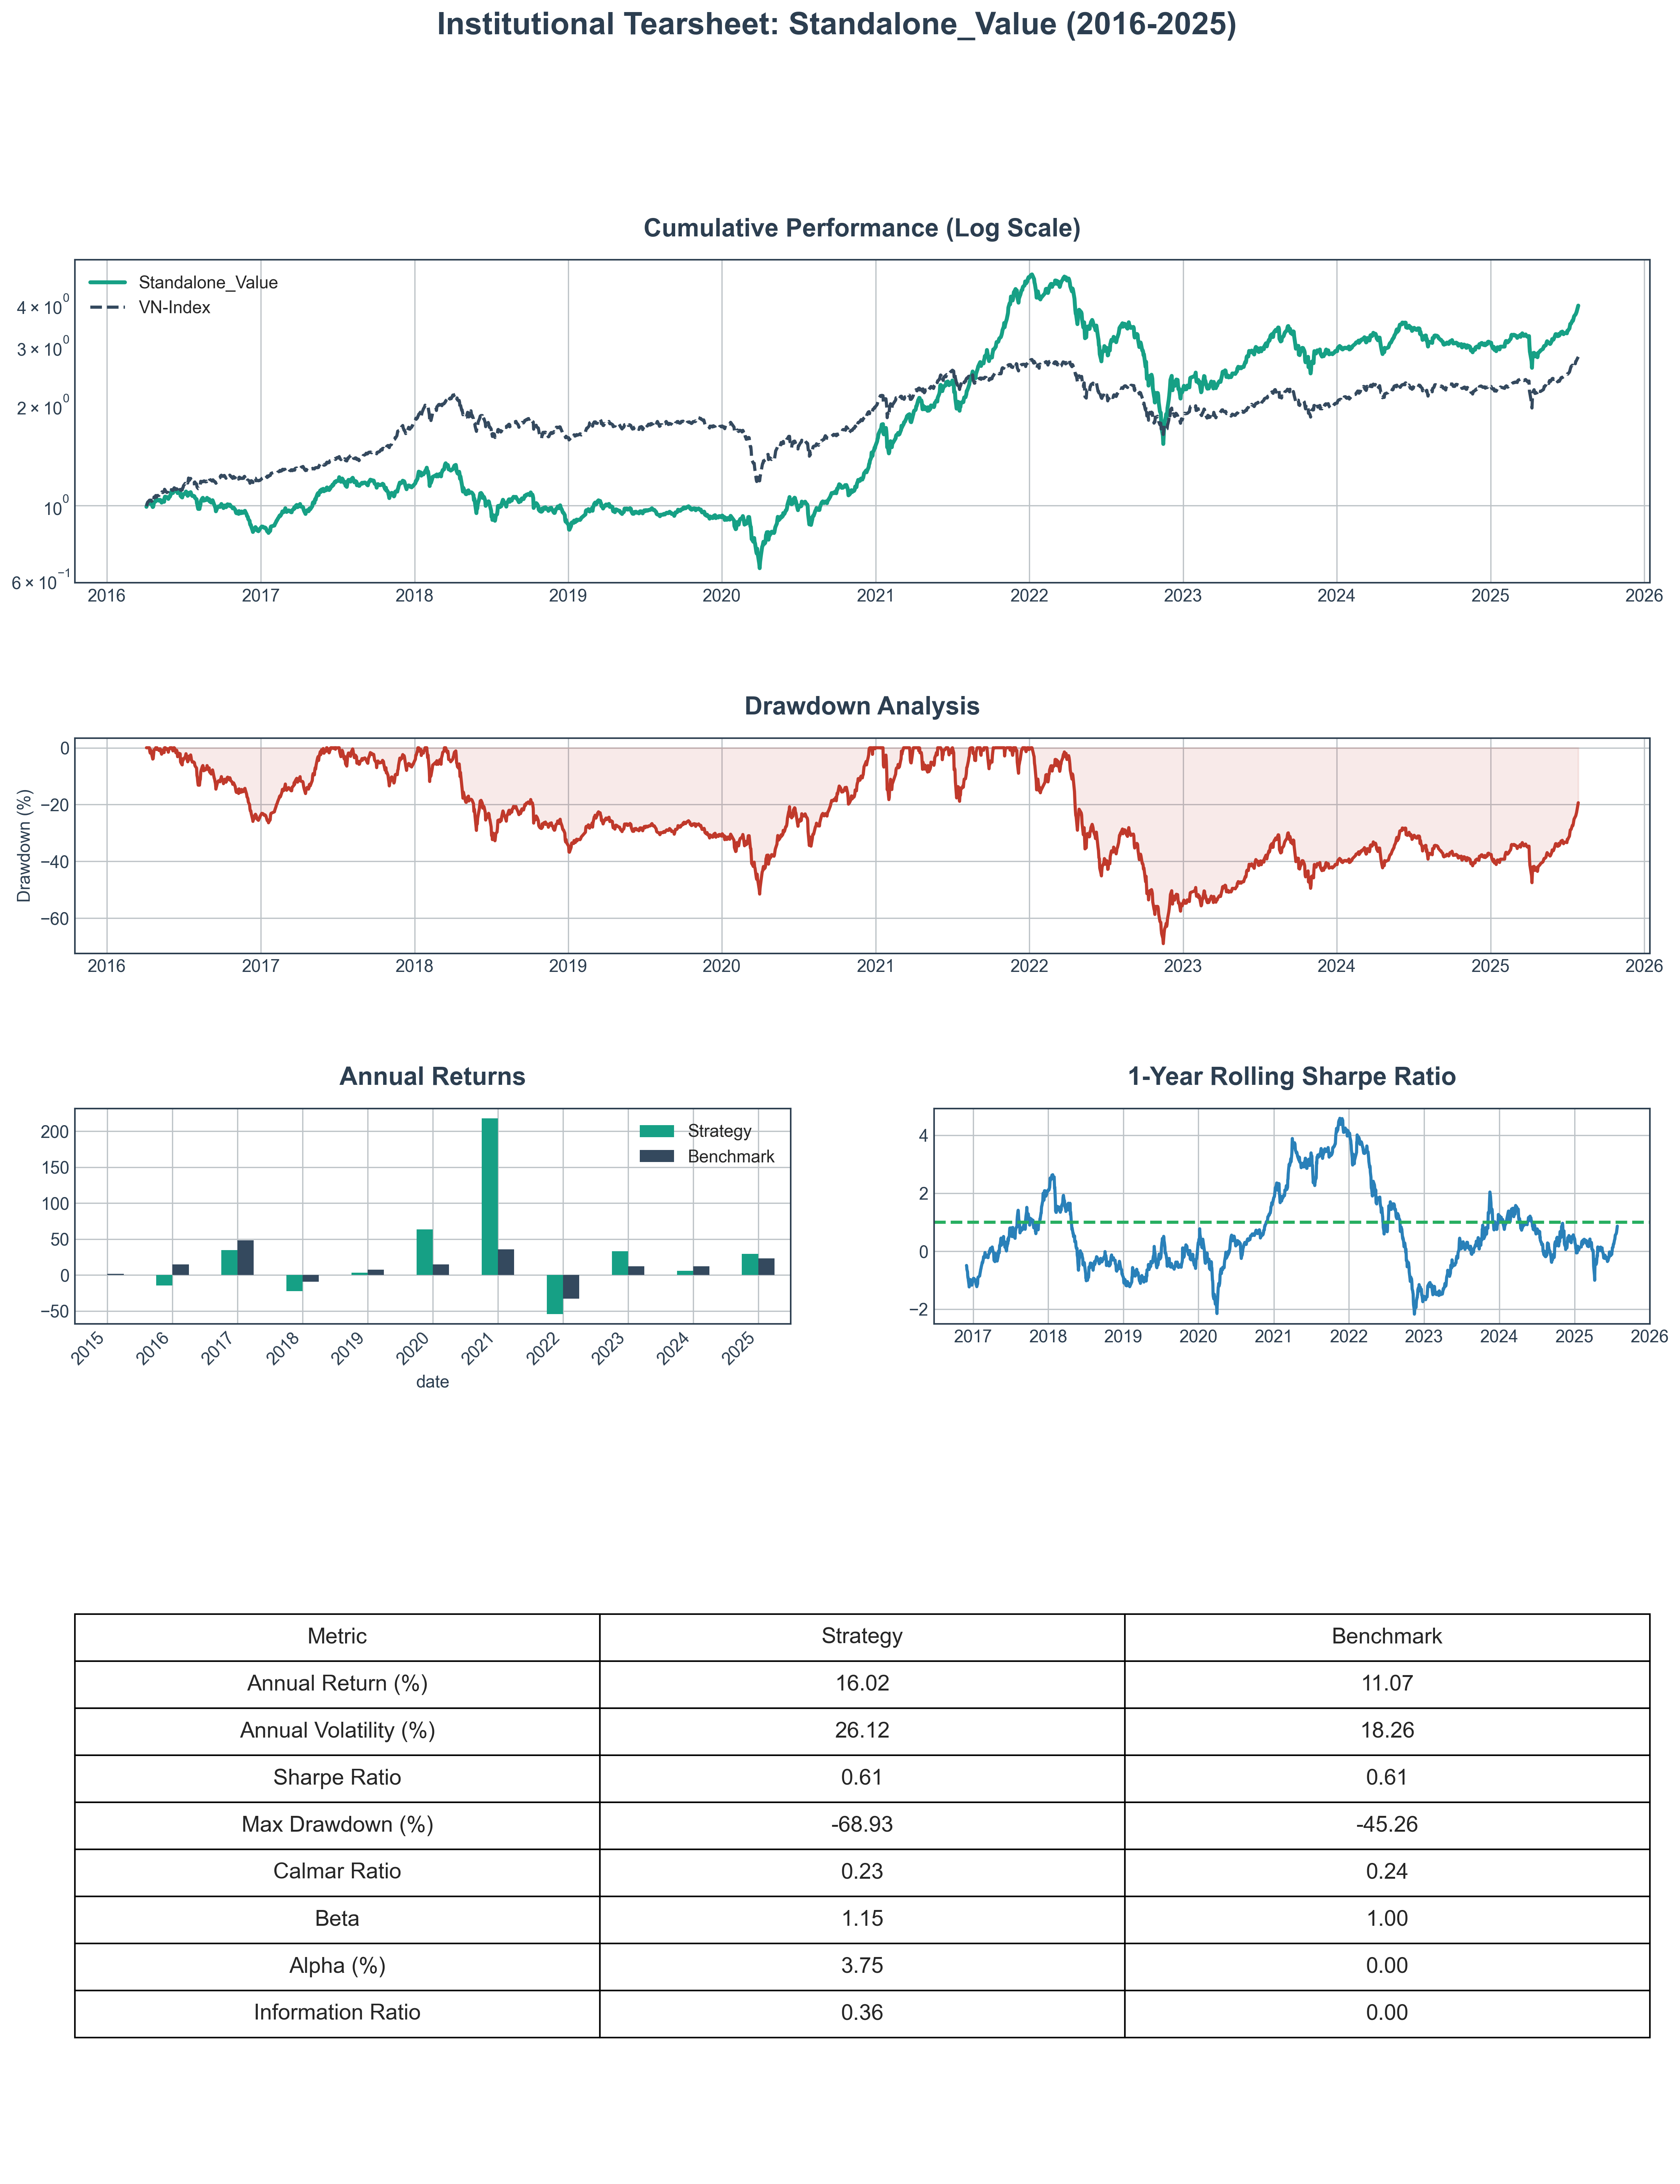


✅ Backtest for start date 2016-03-01 complete.

---
✅ SINGLE BACKTEST COMPLETE for start date: 2016-03-01


In [5]:
# ============================================================================
# EXECUTION: RUN A SINGLE, FOCUSED BACKTEST
# ============================================================================

print("="*80)
print(f"🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")
print("="*80)

# 1. Instantiate the backtester with the single run configuration
#    (Ensure the CanonicalBacktester v1.4 class is defined in a cell above)
backtester = CanonicalBacktester(
    config=SINGLE_RUN_CONFIG,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine
)

# 2. Execute the run() method
#    This will perform all phases and generate the full tearsheet for this specific period.
net_returns = backtester.run()

print("\n---")
print(f"✅ SINGLE BACKTEST COMPLETE for start date: {SINGLE_RUN_CONFIG['backtest_start_date']}")

In [6]:
# ============================================================================
# CONFIGURATION FOR A SINGLE BACKTEST RUN
# ============================================================================

# EDIT THIS START DATE TO TEST DIFFERENT PERIODS
start_date_to_test = '2017-03-01'

# --- Define the single configuration for this run ---
SINGLE_RUN_CONFIG = {
    "strategy_name": "Standalone_Value",
    "factor_to_use": "Value_Composite",
    "backtest_start_date": start_date_to_test,
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "portfolio_size": 20,
    "transaction_cost_bps": 30,
    "strategy_version_db": "qvm_v2.0_enhanced"
}

print("✅ Configuration set for a single backtest run.")
print(f"   - Strategy: {SINGLE_RUN_CONFIG['strategy_name']}")
print(f"   - Period: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")

✅ Configuration set for a single backtest run.
   - Strategy: Standalone_Value
   - Period: 2017-03-01 to 2025-07-28


🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: 2017-03-01 to 2025-07-28
✅ CanonicalBacktester v1.3 (Full Tearsheet) initialized for strategy: 'Standalone_Value'

--- Executing Backtest for Period: 2017-03-01 to 2025-07-28 ---
Constructing liquid universe for 2017-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 590 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 590
    Sample result: ('AAA', 42, 28.265655714285717, 1415.9868445714285)
    Before filters: 590 stocks
    Trading days range: 1-42 (need >= 37)
    ADTV range: 0.001-189.960B VND (need >= 10.0)
    Stocks passing trading days filter: 390
    Stocks passing ADTV filter: 75
    After filters: 74 stocks
✅ Universe constructed: 74 stocks
  ADTV range: 10.4B - 190.0B VND
  Market cap range: 318.5B - 194113.2B VND
  Adding sector information...
Constructing liquid 

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_48314/1846691281.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


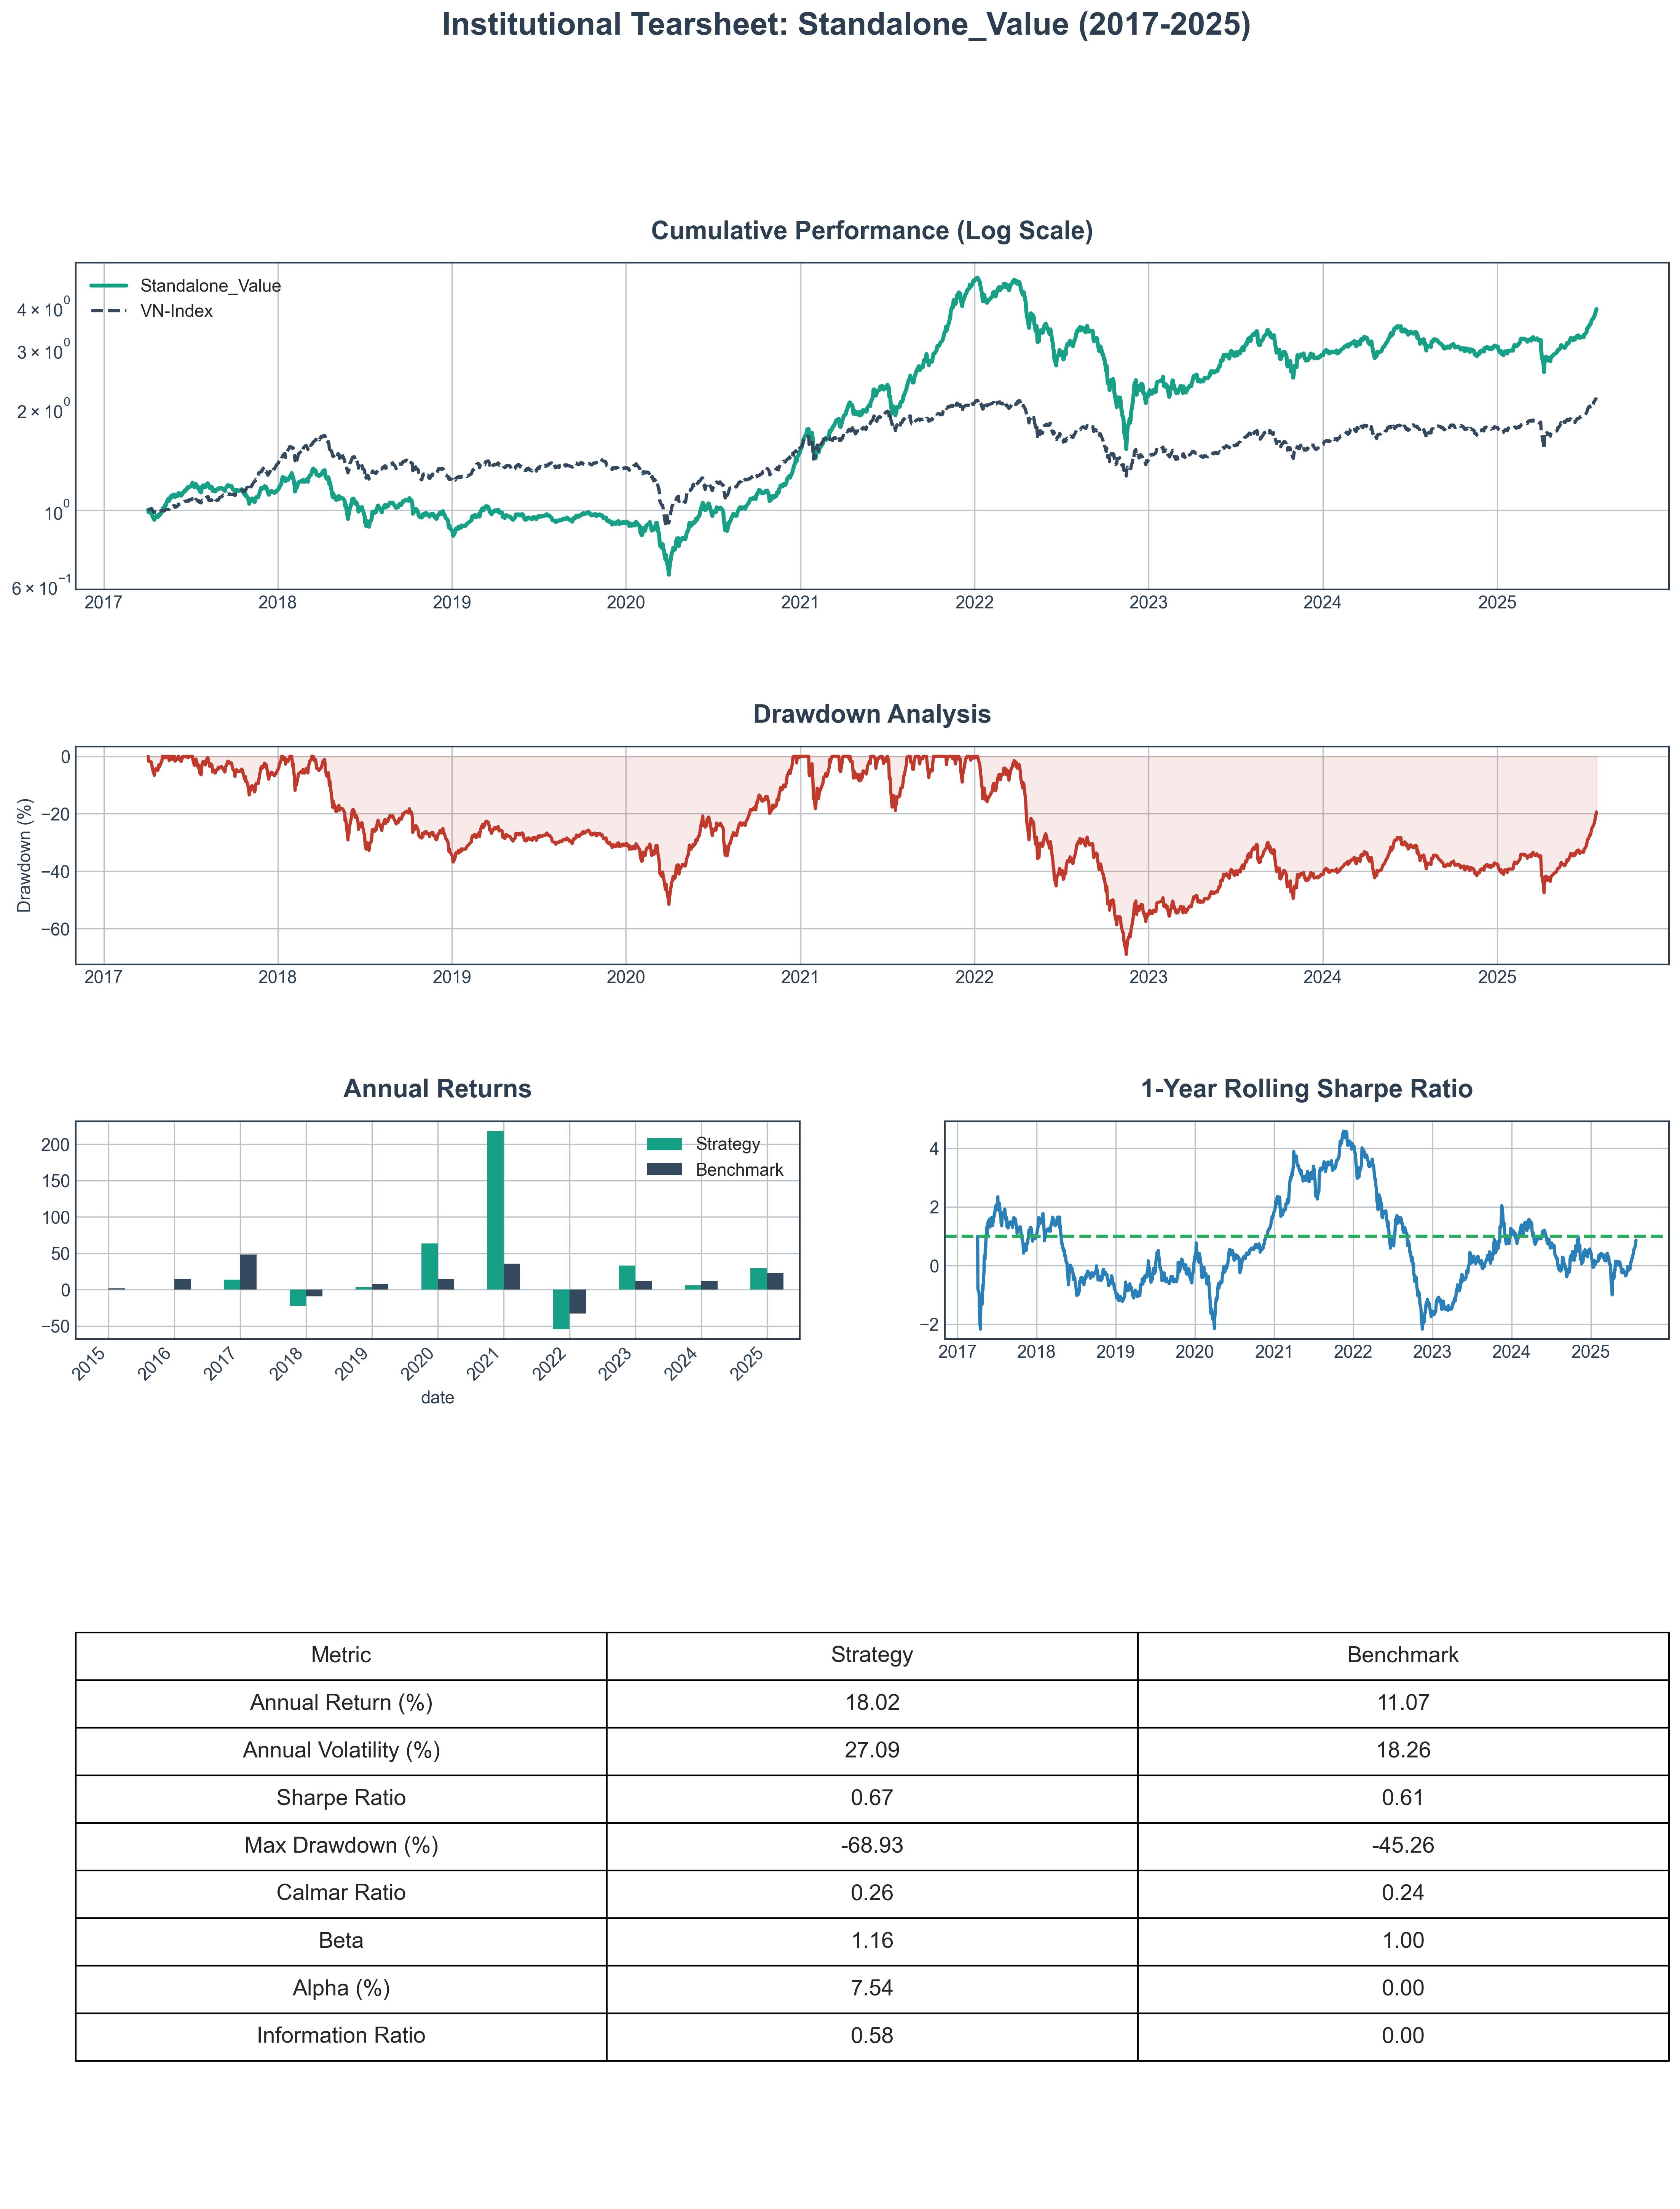


✅ Backtest for start date 2017-03-01 complete.

---
✅ SINGLE BACKTEST COMPLETE for start date: 2017-03-01


In [7]:
# ============================================================================
# EXECUTION: RUN A SINGLE, FOCUSED BACKTEST
# ============================================================================

print("="*80)
print(f"🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")
print("="*80)

# 1. Instantiate the backtester with the single run configuration
#    (Ensure the CanonicalBacktester v1.4 class is defined in a cell above)
backtester = CanonicalBacktester(
    config=SINGLE_RUN_CONFIG,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine
)

# 2. Execute the run() method
#    This will perform all phases and generate the full tearsheet for this specific period.
net_returns = backtester.run()

print("\n---")
print(f"✅ SINGLE BACKTEST COMPLETE for start date: {SINGLE_RUN_CONFIG['backtest_start_date']}")

In [8]:
# ============================================================================
# CONFIGURATION FOR A SINGLE BACKTEST RUN
# ============================================================================

# EDIT THIS START DATE TO TEST DIFFERENT PERIODS
start_date_to_test = '2018-03-01'

# --- Define the single configuration for this run ---
SINGLE_RUN_CONFIG = {
    "strategy_name": "Standalone_Value",
    "factor_to_use": "Value_Composite",
    "backtest_start_date": start_date_to_test,
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "portfolio_size": 20,
    "transaction_cost_bps": 30,
    "strategy_version_db": "qvm_v2.0_enhanced"
}

print("✅ Configuration set for a single backtest run.")
print(f"   - Strategy: {SINGLE_RUN_CONFIG['strategy_name']}")
print(f"   - Period: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")

✅ Configuration set for a single backtest run.
   - Strategy: Standalone_Value
   - Period: 2018-03-01 to 2025-07-28


🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: 2018-03-01 to 2025-07-28
✅ CanonicalBacktester v1.3 (Full Tearsheet) initialized for strategy: 'Standalone_Value'

--- Executing Backtest for Period: 2018-03-01 to 2025-07-28 ---
Constructing liquid universe for 2018-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 645 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/13...
  Step 3: Filtering and ranking...
    Total batch results: 645
    Sample result: ('AAA', 41, 34.33390243902439, 2298.99967)
    Before filters: 645 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-417.736B VND (need >= 10.0)
    Stocks passing trading days filter: 401
    Stocks passing ADTV filter: 97
    After filters: 95 stocks
✅ Universe constructed: 95 stocks
  ADTV range: 10.6B - 417.7B VND
  Market cap range: 304.2B - 296549.8B VND
  Adding sector information...
Constructing liquid universe 

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_48314/1846691281.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


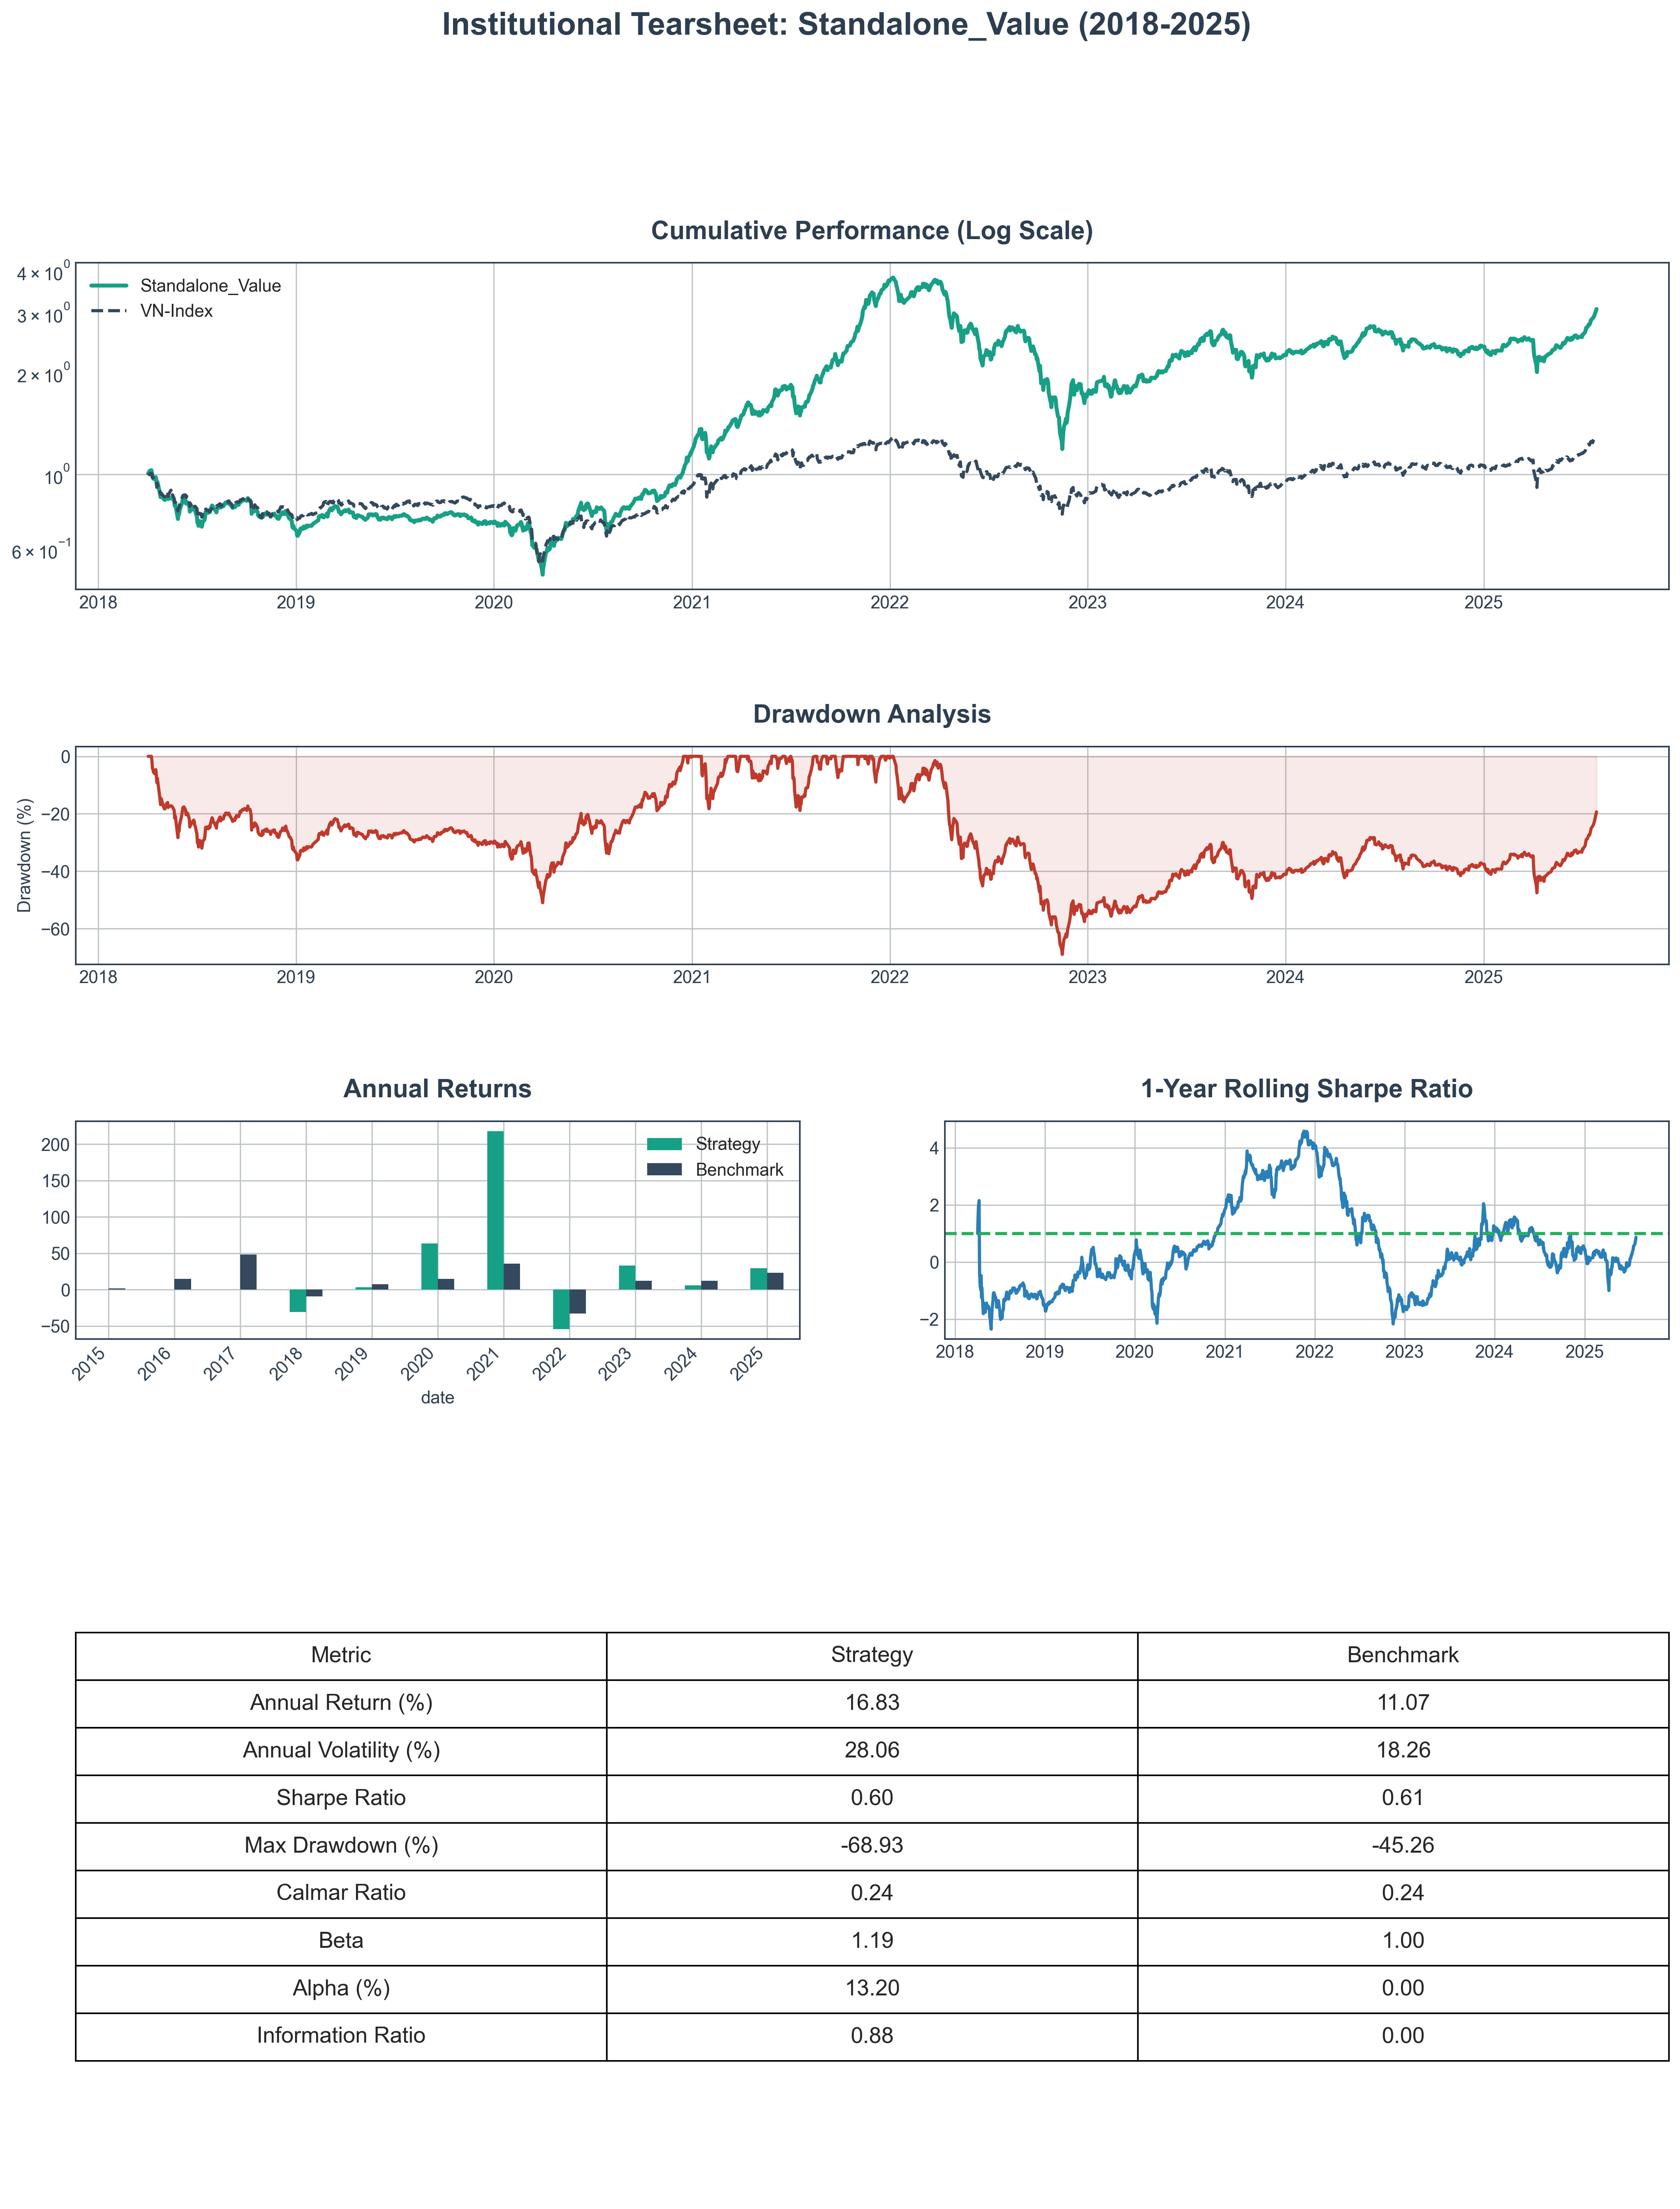


✅ Backtest for start date 2018-03-01 complete.

---
✅ SINGLE BACKTEST COMPLETE for start date: 2018-03-01


In [9]:
# ============================================================================
# EXECUTION: RUN A SINGLE, FOCUSED BACKTEST
# ============================================================================

print("="*80)
print(f"🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")
print("="*80)

# 1. Instantiate the backtester with the single run configuration
#    (Ensure the CanonicalBacktester v1.4 class is defined in a cell above)
backtester = CanonicalBacktester(
    config=SINGLE_RUN_CONFIG,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine
)

# 2. Execute the run() method
#    This will perform all phases and generate the full tearsheet for this specific period.
net_returns = backtester.run()

print("\n---")
print(f"✅ SINGLE BACKTEST COMPLETE for start date: {SINGLE_RUN_CONFIG['backtest_start_date']}")

In [10]:
# ============================================================================
# CONFIGURATION FOR A SINGLE BACKTEST RUN
# ============================================================================

# EDIT THIS START DATE TO TEST DIFFERENT PERIODS
start_date_to_test = '2020-03-01'

# --- Define the single configuration for this run ---
SINGLE_RUN_CONFIG = {
    "strategy_name": "Standalone_Value",
    "factor_to_use": "Value_Composite",
    "backtest_start_date": start_date_to_test,
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "portfolio_size": 20,
    "transaction_cost_bps": 30,
    "strategy_version_db": "qvm_v2.0_enhanced"
}

print("✅ Configuration set for a single backtest run.")
print(f"   - Strategy: {SINGLE_RUN_CONFIG['strategy_name']}")
print(f"   - Period: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")

✅ Configuration set for a single backtest run.
   - Strategy: Standalone_Value
   - Period: 2020-03-01 to 2025-07-28


🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: 2020-03-01 to 2025-07-28
✅ CanonicalBacktester v1.3 (Full Tearsheet) initialized for strategy: 'Standalone_Value'

--- Executing Backtest for Period: 2020-03-01 to 2025-07-28 ---
Constructing liquid universe for 2020-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 675 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/14...
  Step 3: Filtering and ranking...
    Total batch results: 675
    Sample result: ('AAA', 44, 24.098066386363634, 1979.3051770727272)
    Before filters: 675 stocks
    Trading days range: 1-44 (need >= 37)
    ADTV range: 0.000-213.031B VND (need >= 10.0)
    Stocks passing trading days filter: 404
    Stocks passing ADTV filter: 80
    After filters: 79 stocks
✅ Universe constructed: 79 stocks
  ADTV range: 10.0B - 213.0B VND
  Market cap range: 533.7B - 340995.1B VND
  Adding sector information...
Constructing liquid 

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_48314/1846691281.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


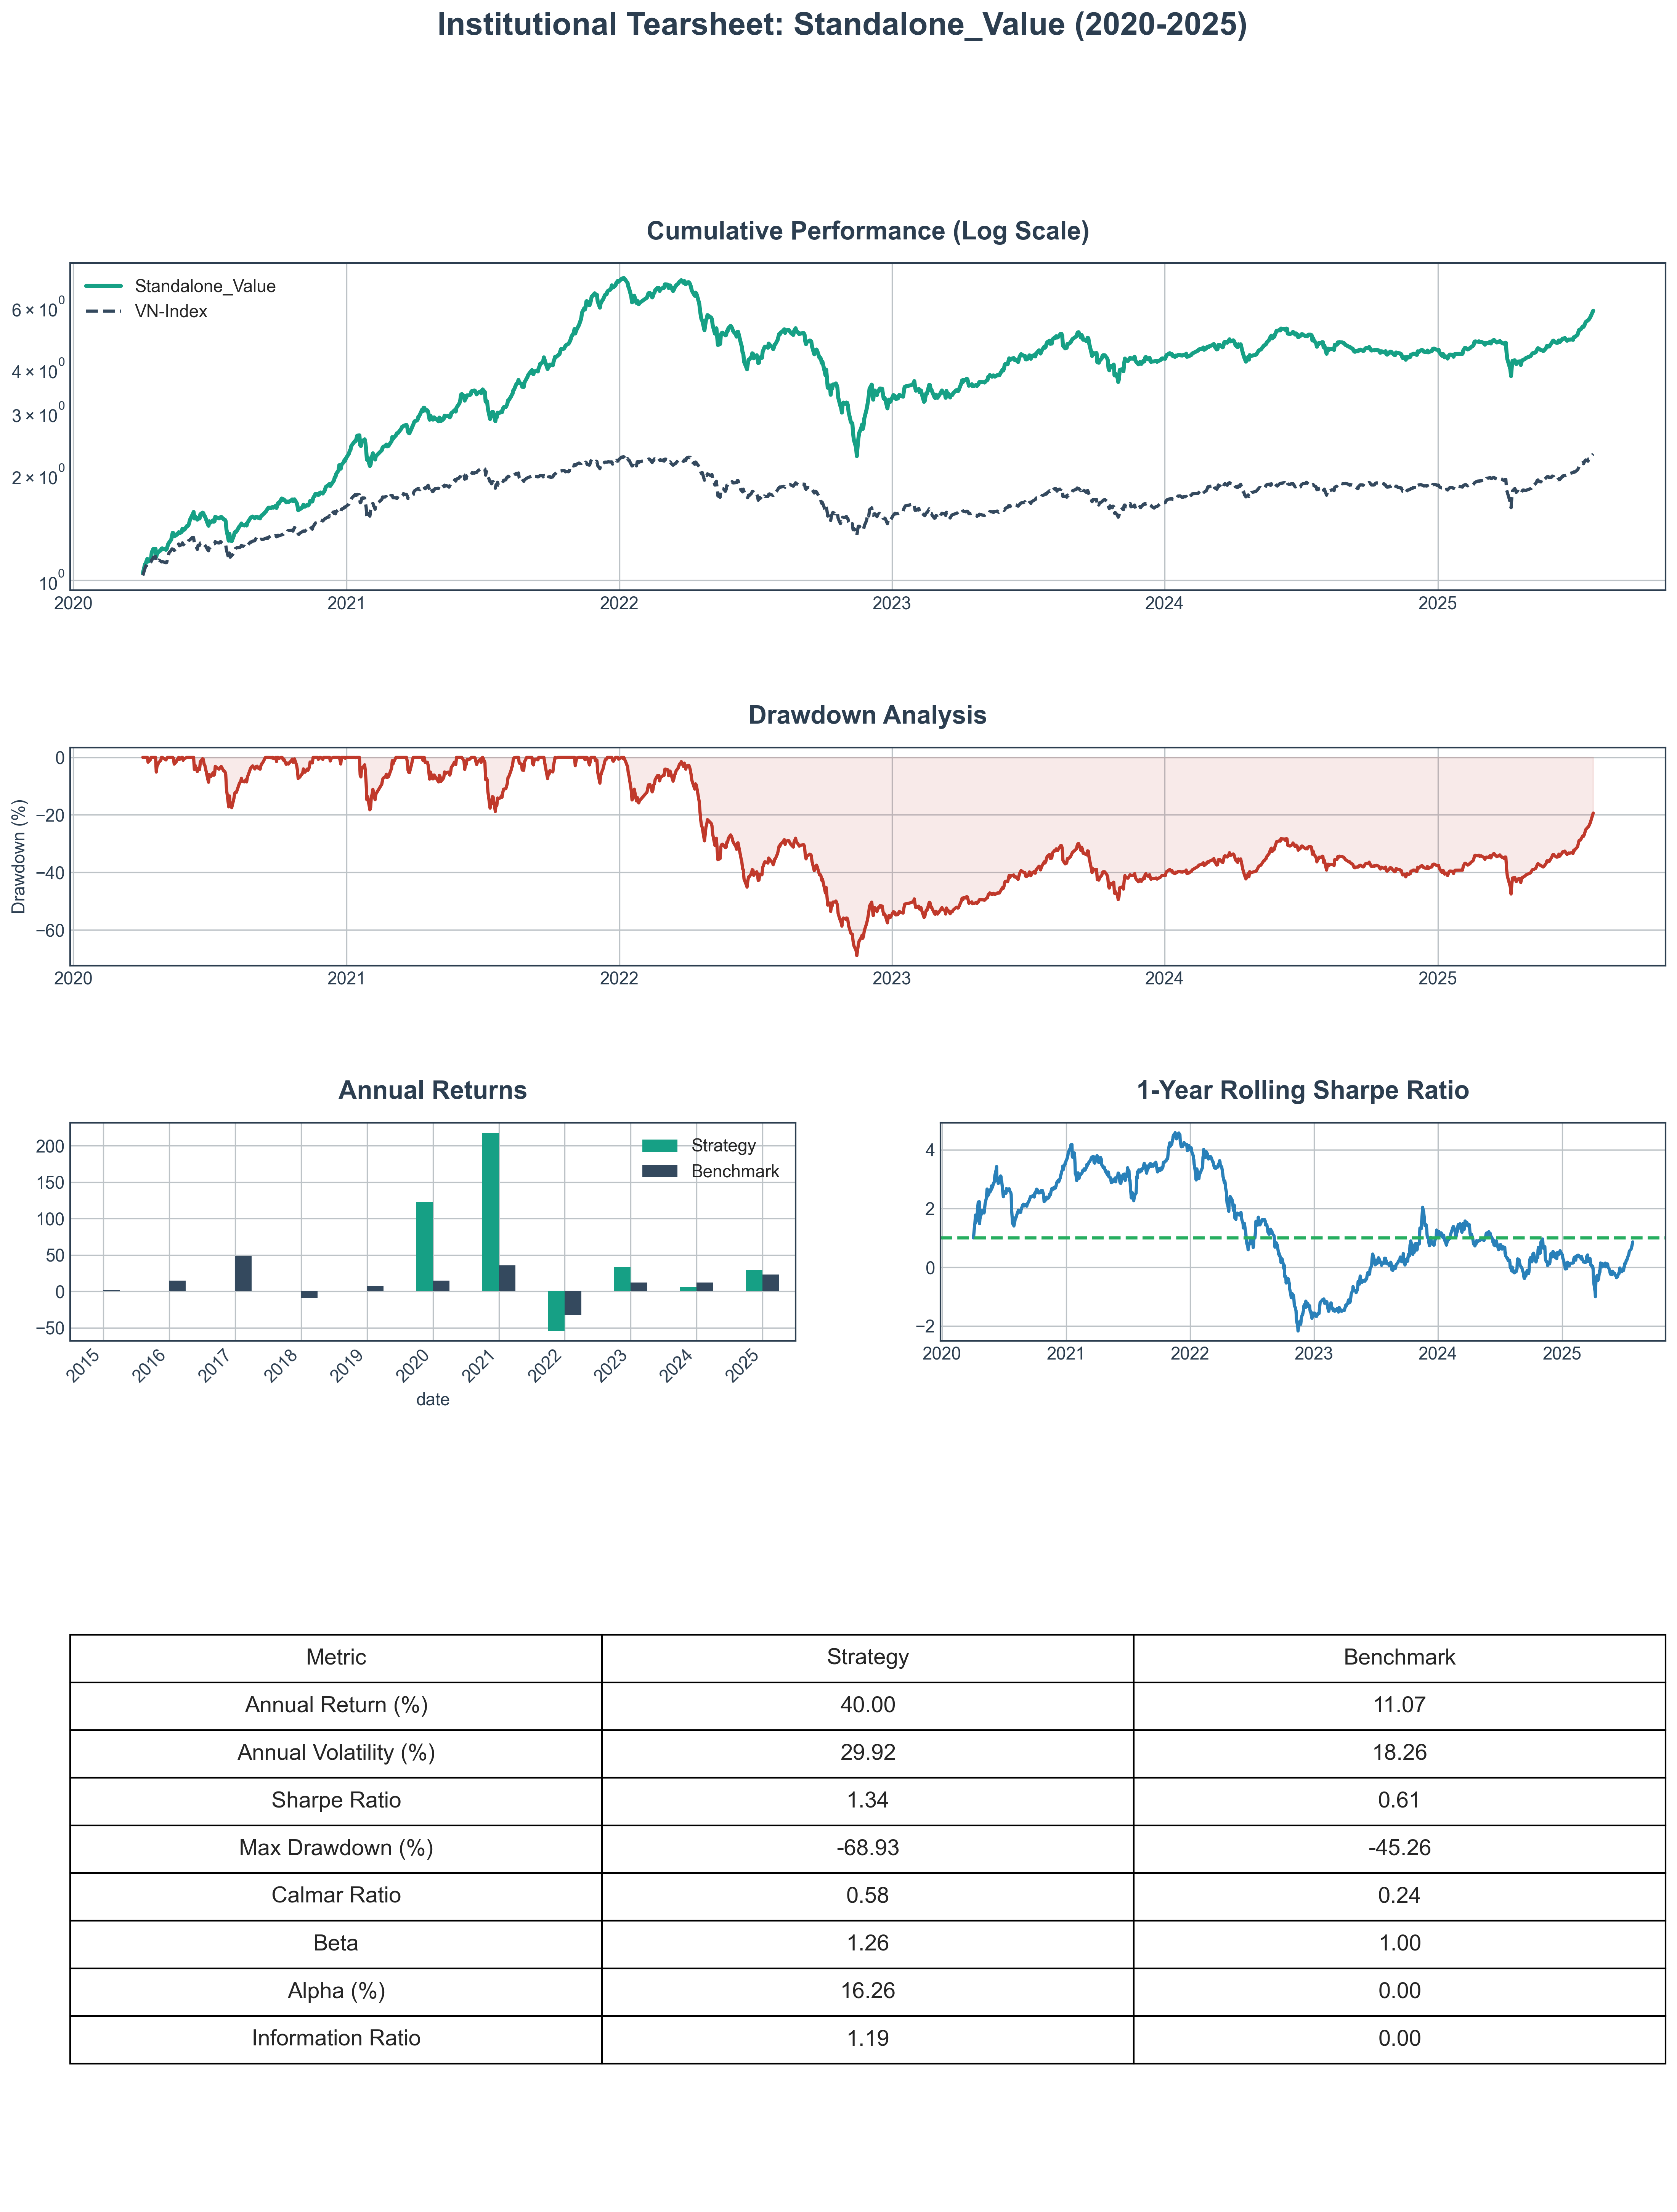


✅ Backtest for start date 2020-03-01 complete.

---
✅ SINGLE BACKTEST COMPLETE for start date: 2020-03-01


In [11]:
# ============================================================================
# EXECUTION: RUN A SINGLE, FOCUSED BACKTEST
# ============================================================================

print("="*80)
print(f"🚀 LAUNCHING SINGLE BACKTEST FOR PERIOD: {SINGLE_RUN_CONFIG['backtest_start_date']} to {SINGLE_RUN_CONFIG['backtest_end_date']}")
print("="*80)

# 1. Instantiate the backtester with the single run configuration
#    (Ensure the CanonicalBacktester v1.4 class is defined in a cell above)
backtester = CanonicalBacktester(
    config=SINGLE_RUN_CONFIG,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine
)

# 2. Execute the run() method
#    This will perform all phases and generate the full tearsheet for this specific period.
net_returns = backtester.run()

print("\n---")
print(f"✅ SINGLE BACKTEST COMPLETE for start date: {SINGLE_RUN_CONFIG['backtest_start_date']}")